# **XGAN: Unsupervised Image-to-Image Translation for Many-to-Many Mapping Problems**

Implementation of XGAN model for automatic cartoon generation from real faces. 

In [171]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/Leinadh/avatar-image-generator.git

Cloning into 'avatar-image-generator'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 33113 (delta 17), reused 30 (delta 8), pack-reused 33068
Receiving objects: 100% (33113/33113), 1.37 GiB | 39.32 MiB/s, done.
Resolving deltas: 100% (76/76), done.
Checking out files: 100% (33640/33640), done.


In [3]:
%cd avatar-image-generator/

/content/avatar-image-generator


In [130]:
!git pull

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 3), reused 5 (delta 3), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/Leinadh/avatar-image-generator
   4fc3c1d7..d88135e2  master     -> origin/master
Updating 4fc3c1d7..d88135e2
Fast-forward
 config_xgan.json                                           |   4 +++-
 datasets/faces_pucp/{ => input_images}/data/danielito.jpeg | Bin
 datasets/faces_pucp/{ => input_images}/data/joel_.jpeg     | Bin
 datasets/faces_pucp/{ => input_images}/data/nigga.jpeg     | Bin
 datasets/faces_pucp/{ => input_images}/data/stev.jpeg      | Bin
 5 files changed, 3 insertions(+), 1 deletion(-)
 rename datasets/faces_pucp/{ => input_images}/data/danielito.jpeg (100%)
 rename datasets/faces_pucp/{ => input_images}/data/joel_.jpeg (100%)
 rename datasets/faces_pucp/{ => input_images}/data/nigga.jpeg (100%)
 rename datasets/faces_pucp/

In [4]:
!pip install -r requirements.txt

     |████████████████████████████████| 1.7MB 5.5MB/s 
     |████████████████████████████████| 3.3MB 4.6MB/s 
     |████████████████████████████████| 122kB 59.3MB/s 
     |████████████████████████████████| 163kB 63.3MB/s 
     |████████████████████████████████| 102kB 12.6MB/s 
     |████████████████████████████████| 102kB 15.4MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-cp36-none-any.whl size=29072 sha256=d5227b5a740920637271d645e4ba7115c94e82e3e88e8bdf3e0a5cfc06f80064
  Stored in directory: /root/.cache/pip/wheels/d0/bb/c0/6aad88b38f6e46db048bed4cccb904a5897055a8ab6fbd4dfc
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=69b1a452a5da7485dfd86ac7ae02332201145a4f254a2ce18aa737da47621f57
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-

In [ ]:
#use `wandb login --relogin` to force relogin
#!wandb login --relogin

In [161]:
!wandb login 17d2772d85cbda79162bd975e45fdfbf3bb18911

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


carpetas dentro de carpetas para el problema de abajo!

In [6]:
import wandb
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys 

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm
from PIL import Image

import logging

from keras_segmentation.pretrained import pspnet_50_ADE_20K , pspnet_101_cityscapes, pspnet_101_voc12
import cv2
import helper
import json

In [8]:
torch.manual_seed(0)
np.random.seed(0)

In [131]:
def configure_model(config_file):

  config_file = parse_configuration(config_file)

  config = wandb.config                                    ##### steeeev por queeee!!, porque de esta manera todo el config se guarda en wandb!!


  config.root_path = config_file["train_dataset_params"]["root_path"]
  config.dataset_path_faces = config_file["train_dataset_params"]["dataset_path_faces"]
  config.dataset_path_cartoons = config_file["train_dataset_params"]["dataset_path_cartoons"]
  config.dataset_path_test_faces = config_file["train_dataset_params"]["dataset_path_test_faces"]
  config.dataset_path_segmented_faces = config_file["train_dataset_params"]["dataset_path_segmented_faces"]
  config.dataset_path_output_faces = config_file["train_dataset_params"]["dataset_path_output_faces"]
  config.batch_size = config_file["train_dataset_params"]["loader_params"]["batch_size"]
  config.image_size = config_file["train_dataset_params"]["loader_params"]["image_size"]
  config.shuffle = config_file["train_dataset_params"]["loader_params"]["shuffle"]
  config.workers = config_file["train_dataset_params"]["loader_params"]["workers"]
  config.seed = config_file["train_dataset_params"]["loader_params"]["seed"]

  config.save_weights = config_file["train_dataset_params"]["save_weights"]
  config.num_backups = config_file["train_dataset_params"]["num_backups"]
  config.save_path = config_file["train_dataset_params"]["save_path"]

  config.dropout_rate_eshared = config_file["model_hparams"]["dropout_rate_eshared"]
  config.dropout_rate_cdann = config_file["model_hparams"]["dropout_rate_cdann"]
  config.is_train = config_file["model_hparams"]["is_train"]
  config.num_epochs = config_file["model_hparams"]["num_epochs"]
  config.learning_rate_opTotal = config_file["model_hparams"]["learning_rate_opTotal"]
  config.learning_rate_opDisc = config_file["model_hparams"]["learning_rate_opDisc"]
  config.b1_disc = config_file["model_hparams"]["b1_disc"]
  config.learning_rate_opCdann = config_file["model_hparams"]["learning_rate_opCdann"]
  config.b1_cdann = config_file["model_hparams"]["b1_cdann"]
  config.learning_rate_denoiser = config_file["model_hparams"]["learning_rate_denoiser"]
  config.wRec_loss = config_file["model_hparams"]["wRec_loss"]
  config.wClas_loss = config_file["model_hparams"]["wClas_loss"]
  config.wSem_loss = config_file["model_hparams"]["wSem_loss"]
  config.wGen_loss = config_file["model_hparams"]["wGen_loss"]
  config.use_gpu = config_file["model_hparams"]["use_gpu"]

  return config

In [62]:
def parse_configuration(config_file):
    """Loads config file if a string was passed
        and returns the input if a dictionary was passed.
    """
    if isinstance(config_file, str):
        with open(config_file,'r') as json_file:
            return json.load(json_file)
    else:
        return config_file

## Preprocessing images - faces

In [63]:
def get_datasets(config):

  path_faces = config.root_path + config.dataset_path_faces
  path_cartoons = config.root_path + config.dataset_path_cartoons

  transform_faces = transforms.Compose([
                transforms.Resize((config.image_size,config.image_size)) ,
                transforms.ToTensor()
                ])
  
  transform_cartoons = transforms.Compose([
                transforms.CenterCrop(400),
                transforms.Resize((config.image_size,config.image_size)) ,
                transforms.ToTensor()
                ])

  dataset_faces = torchvision.datasets.ImageFolder(path_faces, transform=transform_faces)
  dataset_cartoons = torchvision.datasets.ImageFolder(path_cartoons, transform=transform_cartoons)

  train_dataset_faces, test_dataset_faces = torch.utils.data.random_split(dataset_faces,
                                                                                (int(len(dataset_faces)*0.9),len(dataset_faces) - int(len(dataset_faces)*0.9)))


  train_loader_faces = torch.utils.data.DataLoader(
      train_dataset_faces,
      batch_size=config.batch_size,
      shuffle=config.shuffle,
      num_workers = config.workers)

  test_loader_faces = torch.utils.data.DataLoader(
      test_dataset_faces,
      batch_size=config.batch_size,
      shuffle=config.shuffle,
      num_workers = config.workers)
  

  train_dataset_cartoons, test_dataset_cartoons = torch.utils.data.random_split(dataset_cartoons,
                                                                                  (int(len(dataset_cartoons)*0.9),len(dataset_cartoons) - int(len(dataset_cartoons)*0.9)))


  train_loader_cartoons = torch.utils.data.DataLoader(
      train_dataset_cartoons,
      batch_size=config.batch_size,
      shuffle=config.shuffle,
      num_workers = config.workers)

  test_loader_cartoons = torch.utils.data.DataLoader(
      test_dataset_cartoons,
      batch_size=config.batch_size,
      shuffle=config.shuffle,
      num_workers = config.workers)
  
  return (train_loader_faces, test_loader_faces, train_loader_cartoons, test_loader_cartoons) 


## XGAN Model

### Classes

In [270]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    #c=capacity
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False) # out: 32 x 32 x 32
    self.b1 = nn.BatchNorm2d(32) 
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False) #out: 16 x 16 x 64
    self.b2 = nn.BatchNorm2d(64) 

  def forward(self, x):
    x = F.relu(self.conv1(x)) #try selu
    x = self.b1(x)
    x = F.relu(self.conv2(x))
    x = self.b2(x)

    return x  


class Eshared(nn.Module):
  def __init__(self, dropout_rate=0.5):
    super(Eshared, self).__init__()
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=False)
    self.b3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=False)
    self.b4 = nn.BatchNorm2d(256)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features = 4*4*256, out_features = 1024, bias=False)
    self.bfc1 = nn.BatchNorm1d(1024)
    self.dropout2 = nn.Dropout(dropout_rate)
    self.fc2 = nn.Linear(in_features = 1024, out_features = 1024, bias=False)
    self.bfc2 = nn.BatchNorm1d(1024)

  def forward(self,x):
    x = F.relu(self.conv3(x))
    x = self.b3(x)
    x = F.relu(self.conv4(x))
    x = self.b4(x)
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = self.bfc1(x)
    x = self.dropout2(x)      
    x = F.relu(self.fc2(x))
    x = self.bfc2(x) 

    return x
    

class Dshared(nn.Module):
  def __init__(self):
    super(Dshared, self).__init__()
    #c = capacity
    self.deconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, bias=False)
    self.bd1 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, bias=False)
    self.bd2 = nn.BatchNorm2d(256)
  
  def forward(self,x):
    x = x.view(-1,1024,1,1)
    x = F.relu(self.deconv1(x))
    x = self.bd1(x)
    x = F.relu(self.deconv2(x))
    x = self.bd2(x)

    return x

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    #c = capacity
    self.deconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, bias=False)
    self.bd3 = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, bias=False)
    self.bd4 = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=2, stride=2)
  
  def forward(self,x):
    x = F.relu(self.deconv3(x))
    x = self.bd3(x)
    x = F.relu(self.deconv4(x))
    x = self.bd4(x)
    x = torch.tanh(self.deconv5(x))

    return x


class GradReverse(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x):
    return x.view_as(x)

  @staticmethod
  def backward(ctx, grad_output):
    return grad_output.neg() * 0.5


def grad_reverse(x):
  return GradReverse.apply(x)


class Cdann(nn.Module):
  def __init__(self, dropout_rate):
    super(Cdann, self).__init__()
    self.fc1 = nn.Linear(in_features = 1024, out_features = 512)
    self.fc2 = nn.Linear(in_features = 512 , out_features = 256)
    self.dropout2 = nn.Dropout(dropout_rate)
    self.fc3 = nn.Linear(in_features = 256 , out_features = 128)
    self.fc4 = nn.Linear(in_features = 128 , out_features = 64)
    self.dropout4 = nn.Dropout(dropout_rate)
    self.fc5 = nn.Linear(in_features = 64 , out_features = 32)
    self.fc6 = nn.Linear(in_features = 32 , out_features = 16)
    self.dropout6 = nn.Dropout(dropout_rate)
    self.fc7 = nn.Linear(in_features = 16, out_features = 1)

  def forward(self, x):
    x = grad_reverse(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = self.dropout4(x)
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))
    x = self.dropout6(x)
    x = torch.sigmoid(self.fc7(x))

    return x

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1) # out: 32 x 32 x 32 
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False) # out: 32 x 32 x 32
    self.b2 = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False) # out: 32 x 32 x 32
    self.b3 = nn.BatchNorm2d(32)  
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1) # out: 32 x 32 x 32 
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features = 4*4*32, out_features = 1)

  def forward(self, x):
    x = F.leaky_relu(self.conv1(x), 0.2)
    x = F.leaky_relu(self.conv2(x), 0.2)
    x = self.b2(x)
    x = F.leaky_relu(self.conv3(x), 0.2)
    x = self.b3(x)
    x = F.leaky_relu(self.conv4(x), 0.2)
    x = self.flatten(x)
    x = torch.sigmoid(self.fc1(x))

    return x

class Denoiser(nn.Module):
  def __init__(self):
    super(Denoiser, self).__init__()
    
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2))
    
    self.decoder = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(64, 3, kernel_size=3, padding=1))
    
  def forward(self,x):
    return self.decoder(self.encoder(x))

### Losses functions

In [65]:
def Lrec(image_rec, image_orig):

  image_rec_r = image_rec.view(-1,64*64*3)
  image_orig_r = image_orig.view(-1,64*64*3)
  #mse
  rec_loss = torch.norm(image_rec_r - image_orig_r, p=2, dim=1)
  rec_loss = torch.mean(rec_loss)


  return rec_loss


def Lsem(encoder,encoder_rec):

  encoder = encoder.view(-1,1024)
  encoder_rec = encoder_rec.view(-1,1024)

  sem_loss = torch.norm(encoder - encoder_rec, p=1, dim=1)
  
  sem_loss = torch.mean(sem_loss)

  return sem_loss 


## Utils

In [66]:
def init_logger(log_file=None, log_dir=None):
  
  fmt = '%(asctime)s %(filename)s[line:%(lineno)d] %(levelname)s: %(message)s'

  if log_dir is None:
    log_dir = '~/temp/log/'

  if not os.path.exists(log_dir):
        print("Creating dir")
        os.makedirs(log_dir)

  log_file = os.path.join(log_dir, log_file)

  print('log file path:' + log_file)

  logging.basicConfig(level=logging.INFO,
                      filename=log_file,
                      format=fmt)
  
  
  return logging  

In [67]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        #print('Applied to:: ', m.__class__.__name__)
        #nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.kaiming_uniform_(m.weight.data )
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def save_weights(model, path_gen, path_sub):
  e1, e2, d1, d2, e_shared, d_shared, c_dann, discriminator1, denoiser = model

  torch.save(e1.state_dict(), os.path.join(path_sub, 'e1.pth'))
  torch.save(e2.state_dict(), os.path.join(path_sub, 'e2.pth'))
  torch.save(e_shared.state_dict(), os.path.join(path_sub, 'e_shared.pth'))
  torch.save(d_shared.state_dict(), os.path.join(path_sub, 'd_shared.pth'))
  torch.save(d1.state_dict(), os.path.join(path_sub, 'd1.pth'))
  torch.save(d2.state_dict(), os.path.join(path_sub, 'd2.pth'))
  torch.save(c_dann.state_dict(), os.path.join(path_sub, 'c_dann.pth'))
  torch.save(discriminator1.state_dict(), os.path.join(path_sub, 'disc1.pth'))
  torch.save(denoiser.state_dict(), os.path.join(path_sub, 'denoiser.pth'))



  wandb.save(os.path.join(path_sub,'*.pth'),base_path='/'.join(path_gen.split('/')[:-2]))


## GPU

## Training

In [79]:
def train(config, model, device, train_loader_faces, train_loader_cartoons, optimizers, criterion_bc, criterionDenoiser):
  
  e1, e2, d1, d2, e_shared, d_shared, c_dann, discriminator1, denoiser = model
  optimizerDenoiser, optimizerDisc1, optimizerTotal, optimizerCdann = optimizers 
  
  e1.train()
  e2.train()
  e_shared.train()
  d_shared.train()
  d1.train()
  d2.train()
  c_dann.train()
  discriminator1.train()
  denoiser.train()

  for faces_batch, cartoons_batch in zip(train_loader_faces, train_loader_cartoons):

    faces_batch,_ = faces_batch
    faces_batch = Variable(faces_batch.type(torch.Tensor))
    class_faces = Variable(torch.ones(faces_batch.size(0)))
    faces_batch = faces_batch.to(device)
    class_faces = class_faces.to(device)
    
    cartoons_batch,_ = cartoons_batch
    cartoons_batch = Variable(cartoons_batch.type(torch.Tensor))
    class_cartoons = Variable(torch.zeros(cartoons_batch.size(0)))
    cartoons_batch = cartoons_batch.to(device)
    class_cartoons = class_cartoons.to(device)
    
    e1.zero_grad()
    e2.zero_grad()
    e_shared.zero_grad()
    d_shared.zero_grad()
    d1.zero_grad()
    d2.zero_grad()
    c_dann.zero_grad()
    discriminator1.zero_grad()
    denoiser.zero_grad()

    #architecture
    faces_enc1 = e1(faces_batch)
    faces_encoder = e_shared(faces_enc1)
    faces_decoder = d_shared(faces_encoder)
    faces_rec = d1(faces_decoder)
    cartoons_construct = d2(faces_decoder)
    cartoons_construct_enc2 = e2(cartoons_construct)
    cartoons_construct_encoder = e_shared(cartoons_construct_enc2)

    cartoons_enc2 = e2(cartoons_batch)
    cartoons_encoder = e_shared(cartoons_enc2)
    cartoons_decoder = d_shared(cartoons_encoder)
    cartoons_rec = d2(cartoons_decoder)
    faces_construct = d1(cartoons_decoder)
    faces_construct_enc1 = e1(faces_construct)
    faces_construct_encoder = e_shared(faces_construct_enc1)


    # Denoiser
    cartoons_denoised = denoiser(cartoons_rec.detach())

    # Train Denoiser

    loss_denoiser = criterionDenoiser(cartoons_batch, cartoons_denoised)
    loss_denoiser.backward()
    optimizerDenoiser.step()



    #discriminator face(1)->cartoon(2)

      #train discriminator
    data_cartoons = torch.cat([cartoons_batch, cartoons_construct.detach()], 0)
    label_class = torch.cat([class_cartoons, class_faces], 0)   
    output = discriminator1(data_cartoons) 
    loss_disc1 = criterion_bc(output.squeeze(), label_class)
    loss_disc1.backward()
    optimizerDisc1.step()

    #train generator
    data_classifier = torch.cat([faces_encoder, cartoons_encoder], 0)
    label_classifier = torch.cat([class_faces, class_cartoons], 0)

    label_output = c_dann(data_classifier) 


    loss_rec1 = Lrec(faces_batch, faces_rec)
    loss_rec2 = Lrec(cartoons_batch, cartoons_rec)
    loss_rec =  loss_rec1 + loss_rec2

    error_classifier = criterion_bc(label_output.squeeze(),label_classifier) 

    loss_sem1 = Lsem(faces_encoder.detach(), cartoons_construct_encoder) 
    loss_sem2 = Lsem(cartoons_encoder.detach(), faces_construct_encoder) 
    loss_sem = loss_sem1 + loss_sem2

          
    class_faces.fill_(0)

    output = discriminator1(cartoons_construct)

    loss_gen1 = criterion_bc(output.squeeze(), class_faces)



    loss_total = loss_rec + error_classifier + config.wSem_loss*loss_sem + config.wGen_loss*loss_gen1
    loss_total.backward()


    optimizerTotal.step()
    optimizerCdann.step()


  return loss_rec1, loss_rec2, error_classifier,loss_sem1, loss_sem2, loss_disc1, loss_gen1, loss_total, loss_denoiser

In [219]:
def remove_background_image(model, path_filename, output_path):


    output_file = path_filename.split('/')[-1].split('.')[0] + "_wo_bg.jpg"

    out = model.predict_segmentation(
      inp= path_filename,
      out_fname= output_path + output_file
    )

    img_mask = cv2.imread(output_path + output_file)
    img1 = cv2.imread(path_filename) #READ BGR

    seg_gray = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)
    _,bg_mask = cv2.threshold(seg_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)

    bg_mask = cv2.cvtColor(bg_mask, cv2.COLOR_GRAY2BGR)

    bg = cv2.bitwise_or(img1, bg_mask)
    
    cv2.imwrite(output_path + output_file, bg)

In [220]:
def remove_background(path_test_faces, path_segmented_faces):
  model = pspnet_101_voc12()

  path = path_test_faces + 'data/'
  output_path = path_segmented_faces + 'data/'

  dir_path = os.path.dirname(output_path)
  if not os.path.exists(dir_path):
    os.makedirs(dir_path)

  for filename in tqdm(os.listdir(path)):

    remove_background_image(model, path + filename, output_path)

In [155]:
def get_test_images(config, path_test_faces, path_segmented_faces):

  remove_background(path_test_faces, path_segmented_faces)

  path_test_images = path_segmented_faces

  transform = transforms.Compose([
                                
                  transforms.Resize((config.image_size,config.image_size)) ,
                  transforms.CenterCrop(64), 
                  transforms.ToTensor(),
                  # transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                  ])

  dataset_test_images = torchvision.datasets.ImageFolder(path_test_images, transform=transform)

  test_loader_images = torch.utils.data.DataLoader(
      dataset_test_images,
      batch_size=config.batch_size,
      shuffle=True,
      num_workers = config.workers)

  dataiter = iter(test_loader_images)
  test_images = dataiter.next()


  return test_images

In [156]:
def test_image(model, device, images_faces):

  e1, e2, d1, d2, e_shared, d_shared, c_dann, discriminator1, denoiser = model

  e1.eval()
  e2.eval()
  e_shared.eval()
  d_shared.eval()
  d1.eval()
  d2.eval()
  c_dann.eval()
  discriminator1.eval()
  denoiser.eval()

  with torch.no_grad():
      output = e1(images_faces[0].to(device))
      output = e_shared(output)
      output = d_shared(output)
      output = d2(output)
      output = denoiser(output)
    

  # generated_images = torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0)

  return output.cpu()

In [157]:
def init_optimizers(model, config):

  e1, e2, d1, d2, e_shared, d_shared, c_dann, discriminator1, denoiser = model

  listDisc1 = list(discriminator1.parameters())
  optimizerDisc1 = torch.optim.Adam(listDisc1, lr=config.learning_rate_opDisc, betas=(config.b1_disc, 0.999))

  listParameters = list(e1.parameters()) + list(e2.parameters()) + list(e_shared.parameters()) + list(d_shared.parameters()) + list(d1.parameters()) + list(d2.parameters())
  optimizerTotal = torch.optim.RMSprop(listParameters, lr=config.learning_rate_opTotal, weight_decay=0.01)

  optimizerCdann = torch.optim.Adam(c_dann.parameters(), lr=config.learning_rate_opCdann, betas=(config.b1_cdann, 0.999))

  optimizerDenoiser = torch.optim.Adam(denoiser.parameters(), lr=config.learning_rate_denoiser)

  return (optimizerDenoiser, optimizerDisc1, optimizerTotal, optimizerCdann) 

In [158]:
def init_model(device, config, use_wandb=True):

  e1 = Encoder()
  e2 = Encoder()
  e_shared = Eshared(config.dropout_rate_eshared)
  d_shared = Dshared()
  d1 = Decoder()
  d2 = Decoder()
  c_dann = Cdann(config.dropout_rate_cdann)
  discriminator1 = Discriminator()
  denoiser = Denoiser()

  e1.to(device)
  e2.to(device)
  e_shared.to(device)
  d_shared.to(device)
  d1.to(device)
  d2.to(device)
  c_dann.to(device)
  discriminator1.to(device)
  denoiser = denoiser.to(device)
  
  e1.apply(weights_init)
  e2.apply(weights_init)
  e_shared.apply(weights_init)
  d_shared.apply(weights_init)
  d1.apply(weights_init)
  d2.apply(weights_init)
  c_dann.apply(weights_init)
  discriminator1.apply(weights_init)
  denoiser.apply(weights_init)

  if use_wandb:
    wandb.watch(e1, log="all")
    wandb.watch(e2, log="all")
    wandb.watch(e_shared, log="all")
    wandb.watch(d_shared, log="all")
    wandb.watch(d1, log="all")
    wandb.watch(d2, log="all")
    wandb.watch(c_dann, log="all")
    wandb.watch(discriminator1, log="all")
    wandb.watch(denoiser, log="all")

  return (e1, e2, d1, d2, e_shared, d_shared, c_dann, discriminator1, denoiser)


In [160]:
config_file = {
	"train_dataset_params": {
    "root_path": "/content/avatar-image-generator/",
		"dataset_path_faces": "datasets/face_datasets/face_images_wo_bg_permissive/",
		"dataset_path_cartoons": "datasets/cartoon_datasets/cartoonset10k/",
    "dataset_path_test_faces":"datasets/faces_pucp/input_images/",
    "dataset_path_segmented_faces" : "datasets/faces_pucp/segmented_faces/",
    "dataset_path_output_faces" : "datasets/faces_pucp/generated_cartoon_images/",
		"loader_params": {
			"batch_size": 32,
			"image_size": 64,
			"shuffle": True,
			"workers": 4,
			"seed": 0
		},
		"save_weights": True,
		"num_backups": 5,
		"save_path": "weights/"
	},
	"model_hparams": {
		"dropout_rate_eshared": 0.5,
		"dropout_rate_cdann": 0.5,
		"is_train": True,
		"num_epochs": 5,
		"learning_rate_opTotal": 1e-4,
		"learning_rate_opDisc": 1e-3,
		"b1_disc": 0.5,
		"learning_rate_opCdann": 1e-3,
		"b1_cdann": 0.99,
		"learning_rate_denoiser": 1e-3,
		"wRec_loss": 1.0,
		"wClas_loss": 1.0,
		"wSem_loss": 0.5,
		"wGen_loss": 0.7,
		"use_gpu": True
	}
}





In [162]:
def model_train(config_file):

  wandb.init(project="avatar_image_generator")
  wandb.watch_called = False

  config = configure_model(config_file)

  device = torch.device("cuda:0" if config.use_gpu and torch.cuda.is_available() else "cpu")

  if config.save_weights:
    path_save_weights = config.root_path + config.save_path
    try:
        os.mkdir(path_save_weights)
    except OSError:
        pass

  logging = init_logger(log_file='logfile.log',log_dir=path_save_weights)

  train_loader_faces, test_loader_faces, train_loader_cartoons, test_loader_cartoons = get_datasets(config)

  model = init_model(device, config)
  optimizers = init_optimizers(model, config)

  train_loss_rec1 = []
  train_loss_rec2 = []
  train_loss_cdan = []
  train_loss_sem1 = []
  train_loss_sem2 = []
  train_disc1 = []
  train_gen1 = []
  train_loss_total = []
  train_loss_denoiser = []

  criterion_bc = nn.BCELoss()
  criterionDenoiser = nn.L1Loss()

  criterion_bc.to(device) 
  criterionDenoiser.to(device) 

  # dataiter = iter(test_loader_faces)
  # images_faces_to_test = dataiter.next()

  images_faces_to_test = get_test_images(config, config.root_path + config.dataset_path_test_faces, config.root_path + config.dataset_path_segmented_faces)

  for epoch in tqdm(range(config.num_epochs)):
    loss_rec1, loss_rec2, error_classifier,loss_sem1, loss_sem2, loss_disc1, loss_gen1, loss_total, loss_denoiser = train(config, model, device, train_loader_faces, train_loader_cartoons, optimizers, criterion_bc, criterionDenoiser)
    generated_images = test_image(model, device, images_faces_to_test)


    logging.info('Train Epoch [{}/{}], Loss rec1: {:.4f}, Loss rec2: {:.4f},'
                                      ' Loss classifier: {:.4f}, Loss semantic 1->2: {:.4f}, Loss semantic 2->1: {:.4f},'
                                      ' Loss disc1: {:.4f}, Loss gen1: {:.4f}, Loss total: {:.4f}'
                                      .format(epoch+1, config.num_epochs, loss_rec1.item(),
                                              loss_rec2.item(), error_classifier.item(),
                                              loss_sem1.item(), loss_sem2.item(),
                                              loss_disc1.item(), loss_gen1.item(), loss_total.item()))

    wandb.log({"train_epoch":epoch+1,
               "Generated images": [wandb.Image(img) for img in generated_images],
              "loss_rec1":loss_rec1.item(),
              "loss_rec2":loss_rec2.item(),
              "loss_classifier":error_classifier.item(),
              "loss_semantic12":loss_sem1.item(),
              "loss_semantic21":loss_sem2.item(),
              "loss_disc1":loss_disc1.item(),
              "loss_gen1":loss_gen1.item(),
              "loss_total":loss_total.item()})


    if config.save_weights and ((epoch+1)% int(config.num_epochs/config.num_backups))==0:
      path_save_epoch = path_save_weights + 'epoch_{}'.format(epoch+1)
      try:
          os.mkdir(path_save_epoch)
      except OSError:
          pass
      save_weights(model, path_save_weights, path_save_epoch)      
      logging.info(f'Checkpoint {epoch + 1} saved !')

    train_loss_rec1.append(loss_rec1.item())
    train_loss_rec2.append(loss_rec2.item())
    train_loss_cdan.append(error_classifier.item())
    train_loss_sem1.append(loss_sem1.item())
    train_loss_sem2.append(loss_sem2.item())
    train_disc1.append(loss_disc1.item())
    train_gen1.append(loss_gen1.item())
    train_loss_total.append(loss_total.item())
    train_loss_denoiser.append(loss_denoiser.item())

    print("Losses")
    print('Epoch [{}/{}], Loss rec1: {:.4f}'.format(epoch+1, config.num_epochs, loss_rec1.item()))
    print('Epoch [{}/{}], Loss rec2: {:.4f}'.format(epoch+1, config.num_epochs, loss_rec2.item()))
    print('Epoch [{}/{}], Loss classifier: {:.4f}'.format(epoch+1, config.num_epochs, error_classifier.item()))
    print('Epoch [{}/{}], Loss semantic 1->2: {:.4f}'.format(epoch+1, config.num_epochs, loss_sem1.item()))
    print('Epoch [{}/{}], Loss semantic 2->1: {:.4f}'.format(epoch+1, config.num_epochs, loss_sem2.item()))    
    print('Epoch [{}/{}], Loss disc1: {:.4f}'.format(epoch+1, config.num_epochs, loss_disc1.item()))
    print('Epoch [{}/{}], Loss gen1: {:.4f}'.format(epoch+1, config.num_epochs, loss_gen1.item()))
    print('Epoch [{}/{}], Loss total: {:.4f}'.format(epoch+1, config.num_epochs, loss_total.item()))
    print('Epoch [{}/{}], Loss denoiser: {:.4f}'.format(epoch+1, config.num_epochs, loss_denoiser.item()))

In [163]:
config_file

{'model_hparams': {'b1_cdann': 0.99,
  'b1_disc': 0.5,
  'dropout_rate_cdann': 0.5,
  'dropout_rate_eshared': 0.5,
  'is_train': True,
  'learning_rate_denoiser': 0.001,
  'learning_rate_opCdann': 0.001,
  'learning_rate_opDisc': 0.001,
  'learning_rate_opTotal': 0.0001,
  'num_epochs': 5,
  'use_gpu': True,
  'wClas_loss': 1.0,
  'wGen_loss': 0.7,
  'wRec_loss': 1.0,
  'wSem_loss': 0.5},
 'train_dataset_params': {'dataset_path_cartoons': 'datasets/cartoon_datasets/cartoonset10k/',
  'dataset_path_faces': 'datasets/face_datasets/face_images_wo_bg_permissive/',
  'dataset_path_output_faces': 'datasets/faces_pucp/generated_cartoon_images/',
  'dataset_path_segmented_faces': 'datasets/faces_pucp/segmented_faces/',
  'dataset_path_test_faces': 'datasets/faces_pucp/input_images/',
  'loader_params': {'batch_size': 32,
   'image_size': 64,
   'seed': 0,
   'shuffle': True,
   'workers': 4},
  'num_backups': 5,
  'root_path': '/content/avatar-image-generator/',
  'save_path': 'weights/',
  's

In [164]:
model_train(config_file)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


train_epoch,10
loss_rec1,63.3736
loss_rec2,39.32298
loss_classifier,0.02625
loss_semantic12,325.32278
loss_semantic21,131.38219
loss_disc1,0.00046
loss_gen1,21.59433
loss_total,346.19135
_step,9
_runtime,179


train_epoch,▁▂▃▃▄▅▆▆▇█
loss_rec1,██▇▇▅▃▁▁▁▁
loss_rec2,█▇▆▅▄▃▂▁▂▁
loss_classifier,▆█▁▁▁▂▁▂▄▁
loss_semantic12,█▇▆▆▄▂▁▁▁▂
loss_semantic21,█▆▅▄▃▃▂▁▂▁
loss_disc1,█▃▂▁▁▁▁▂▄▁
loss_gen1,▁▁▁▁▁▁▁▁▇█
loss_total,█▇▅▆▄▂▁▁▁▁
_step,▁▂▃▃▄▅▆▆▇█
_runtime,▁▂▃▃▄▅▆▆▇█


log file path:/content/avatar-image-generator/weights/logfile.log


wandb: WARNING Symlinked 9 files into the W&B run directory, call wandb.save again to sync new files.


Losses
Epoch [1/5], Loss rec1: 120.8826
Epoch [1/5], Loss rec2: 127.0860
Epoch [1/5], Loss classifier: 0.4306
Epoch [1/5], Loss semantic 1->2: 876.6599
Epoch [1/5], Loss semantic 2->1: 718.2544
Epoch [1/5], Loss disc1: 0.0062
Epoch [1/5], Loss gen1: 1.0194
Epoch [1/5], Loss total: 1046.5697
Epoch [1/5], Loss denoiser: 0.2584


wandb: WARNING Symlinked 9 files into the W&B run directory, call wandb.save again to sync new files.


Losses
Epoch [2/5], Loss rec1: 113.6891
Epoch [2/5], Loss rec2: 116.6777
Epoch [2/5], Loss classifier: 0.2982
Epoch [2/5], Loss semantic 1->2: 719.0477
Epoch [2/5], Loss semantic 2->1: 581.8563
Epoch [2/5], Loss disc1: 0.0068
Epoch [2/5], Loss gen1: 1.0051
Epoch [2/5], Loss total: 881.8206
Epoch [2/5], Loss denoiser: 0.2288


wandb: WARNING Symlinked 9 files into the W&B run directory, call wandb.save again to sync new files.


Losses
Epoch [3/5], Loss rec1: 106.5137
Epoch [3/5], Loss rec2: 108.1660
Epoch [3/5], Loss classifier: 0.3347
Epoch [3/5], Loss semantic 1->2: 659.9217
Epoch [3/5], Loss semantic 2->1: 516.9442
Epoch [3/5], Loss disc1: 0.0054
Epoch [3/5], Loss gen1: 1.2417
Epoch [3/5], Loss total: 804.3166
Epoch [3/5], Loss denoiser: 0.2160


wandb: WARNING Symlinked 9 files into the W&B run directory, call wandb.save again to sync new files.


Losses
Epoch [4/5], Loss rec1: 84.1919
Epoch [4/5], Loss rec2: 88.2064
Epoch [4/5], Loss classifier: 0.0537
Epoch [4/5], Loss semantic 1->2: 474.9759
Epoch [4/5], Loss semantic 2->1: 377.9894
Epoch [4/5], Loss disc1: 0.0016
Epoch [4/5], Loss gen1: 1.0693
Epoch [4/5], Loss total: 599.6830
Epoch [4/5], Loss denoiser: 0.2158


wandb: WARNING Symlinked 9 files into the W&B run directory, call wandb.save again to sync new files.


Losses
Epoch [5/5], Loss rec1: 64.4364
Epoch [5/5], Loss rec2: 69.1004
Epoch [5/5], Loss classifier: 0.2103
Epoch [5/5], Loss semantic 1->2: 389.9115
Epoch [5/5], Loss semantic 2->1: 274.0326
Epoch [5/5], Loss disc1: 0.0010
Epoch [5/5], Loss gen1: 0.4936
Epoch [5/5], Loss total: 466.0646
Epoch [5/5], Loss denoiser: 0.1856



## Validating model

In [205]:
def load_weights_xgan(path_load_weights, e1, e2, e_shared, d_shared, d1, d2, denoiser):
  
  e1.load_state_dict(torch.load(path_load_weights + 'e1.pth'))
  e2.load_state_dict(torch.load(path_load_weights + 'e2.pth'))
  e_shared.load_state_dict(torch.load(path_load_weights + 'e_shared.pth'))
  d_shared.load_state_dict(torch.load(path_load_weights + 'd_shared.pth'))
  d1.load_state_dict(torch.load(path_load_weights + 'd1.pth'))
  d2.load_state_dict(torch.load(path_load_weights + 'd2.pth'))
  denoiser.load_state_dict(torch.load(path_load_weights + 'denoiser.pth'))

  return

In [206]:
config = configure_model(config_file)

device = torch.device("cuda:0" if config.use_gpu and torch.cuda.is_available() else "cpu")

In [207]:
train_loader_faces, test_loader_faces, train_loader_cartoons, test_loader_cartoons = get_datasets(config)


In [208]:
model = init_model(device, config)

In [209]:
e1, e2, d1, d2, e_shared, d_shared, c_dann, discriminator1, denoiser = model

In [210]:
  e1.eval()
  e2.eval()
  e_shared.eval()
  d_shared.eval()
  d1.eval()
  d2.eval()
  c_dann.eval()
  discriminator1.eval()
  denoiser.eval()


Denoiser(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode=nearest)
    (3): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [211]:
use_weights_just_trained = False

if not use_weights_just_trained:
  path_load_weights = "/content/drive/My Drive/Made with ML/weights_train_stev_v6/epoch_700/"
  load_weights_xgan(path_load_weights, e1, e2, e_shared, d_shared, d1, d2, denoiser)



### Faces domain

#### Original faces

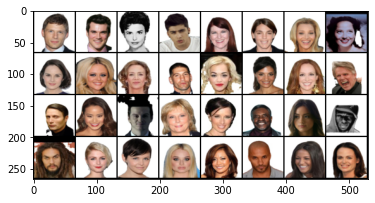

In [212]:
dataiter = iter(test_loader_faces)
images_faces = dataiter.next()

# show images
# print(images[0])
plt.imshow(torchvision.utils.make_grid(images_faces[0]).permute(1, 2, 0))

#### Rec faces

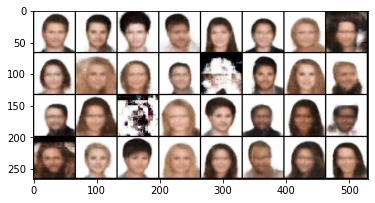

In [213]:
with torch.no_grad():
    output = e1(images_faces[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d1(output)
  

plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0))
plt.show()

#### Face to cartoon

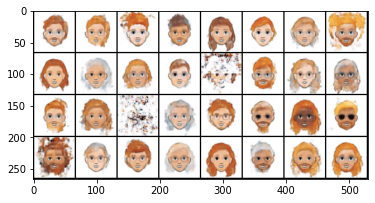

In [214]:
with torch.no_grad():
    output = e1(images_faces[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d2(output)
    output = denoiser(output)
  


plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0))
plt.show()

### Cartoons domain

#### Original cartoons

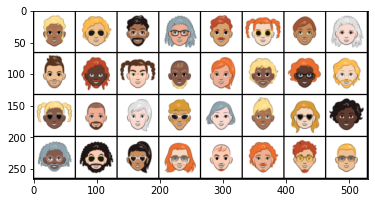

In [215]:
dataiter = iter(test_loader_cartoons)
images_cartoon = dataiter.next()

# show images
# print(images[0])
plt.imshow(torchvision.utils.make_grid(images_cartoon[0]).permute(1, 2, 0))

#### Rec cartoon


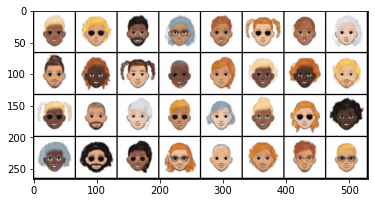

In [216]:
with torch.no_grad():
    output = e2(images_cartoon[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d2(output)
    output = denoiser(output)


plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0))
plt.show()

#### Cartoon to face

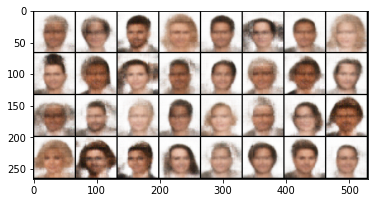

In [217]:
with torch.no_grad():
    output = e2(images_cartoon[0].to(device))
    output = e_shared(output)
    output = d_shared(output)
    output = d1(output)



plt.imshow(torchvision.utils.make_grid(output.cpu()).permute(1, 2, 0))
plt.show()

## Testing model

In [221]:
test_images = get_test_images(config, config.root_path + config.dataset_path_test_faces, config.root_path + config.dataset_path_segmented_faces)


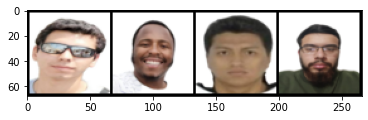

In [222]:
plt.imshow(torchvision.utils.make_grid(test_images[0]).permute(1, 2, 0))

In [224]:
generated_images = test_image(model, device, test_images)

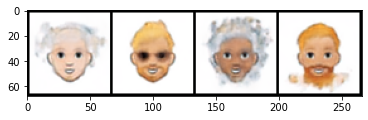

In [225]:
plt.imshow(torchvision.utils.make_grid(generated_images.cpu()).permute(1, 2, 0))
plt.show()

In [274]:
class Avatar_Generator_Model():
    """
    # Methods
    __init__(dict_model): initializer
    dict_model: layers required to perform face-to-image generation (e1, e_shared, d_shared, d2, denoiser)  
    generate(face_image, output_path=None): reutrn cartoon generated from given face image, saves it to output path if given 
    load_weights(weights_path): loads weights from given path
    """

    def __init__(self):
        self.e1 = Encoder()
        self.e_shared = Eshared()
        self.d_shared = Dshared()
        self.d2 = Decoder()
        self.denoiser = Denoiser()

    def generate(self, face_image, output_path=None):


        face = self.__extract_face(face_image)
        return self.__to_cartoon(face, output_path)

    def load_weights(self, weights_path='weights/'):
        self.e1.load_state_dict(torch.load(
            weights_path + 'e1.pth'))
        self.e_shared.load_state_dict(
            torch.load(weights_path + 'e_shared.pth'))
        
        self.d_shared.load_state_dict(
            torch.load(weights_path + 'd_shared.pth'))
        
        self.d2.load_state_dict(torch.load(
            weights_path + 'd2.pth' ))
        
        self.denoiser.load_state_dict(
            torch.load(weights_path + 'denoiser.pth'))
        

    def __extract_face(self, face_image):
        #import model
        # segment image
        # remove background
        # return face
        return face_image

    def __to_cartoon(self, face, output_path):
        self.e1.eval()
        self.e_shared.eval()
        self.d_shared.eval()
        self.d2.eval()
        self.denoiser.eval()


        transform = transforms.Compose(
            [transforms.Resize((64, 64)), transforms.ToTensor()])
        face = transform(face).float()
        X = face.unsqueeze(0)
        with torch.no_grad():
            output = self.e1(X)
            output = self.e_shared(output)
            output = self.d_shared(output)
            output = self.d2(output)
            output = self.denoiser(output)
        if output_path is not None:
            # save to path
            # fileName.jpg part of output_path
            torchvision.utils.save_image(tensor=output, fp=output_path)
        return torchvision.transforms.ToPILImage()(output[0])

In [277]:
image = Image.open("/content/avatar-image-generator/datasets/faces_pucp/input_images/data/joel_.jpeg")

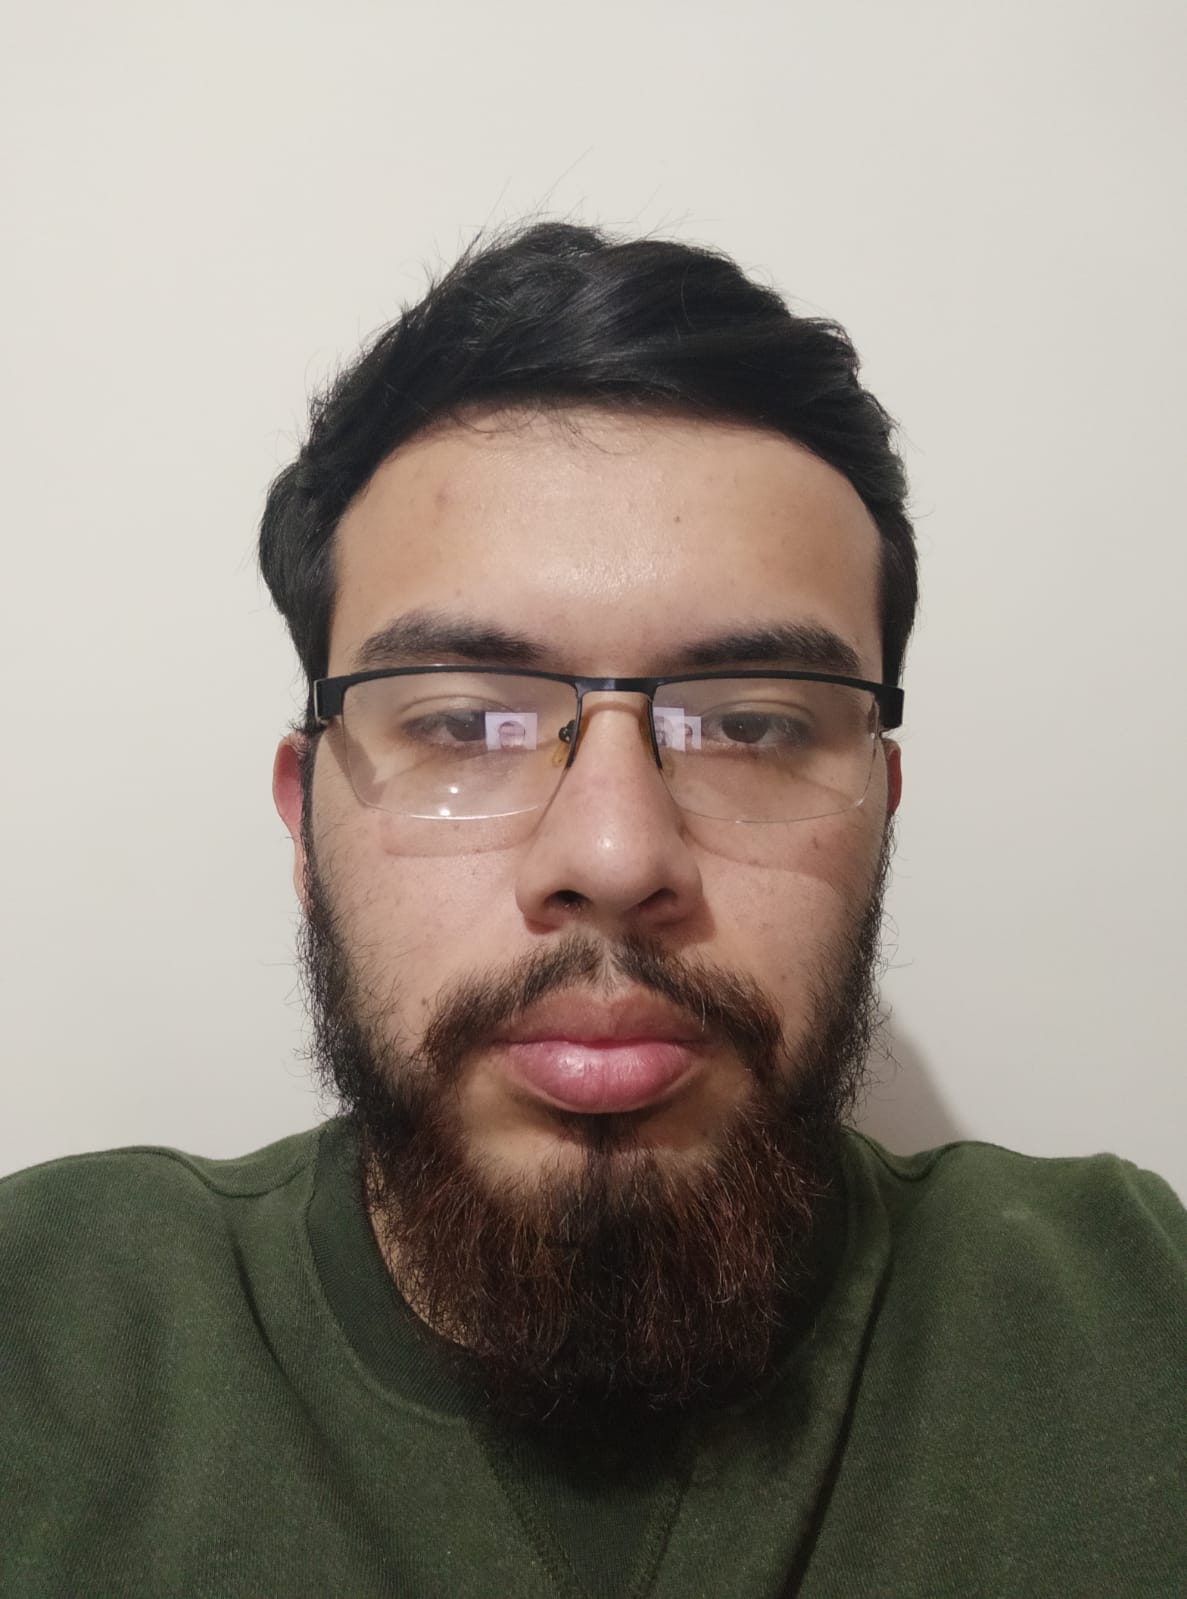

In [278]:
image

In [279]:
model = Avatar_Generator_Model()
model.load_weights("/content/drive/My Drive/Made with ML/weights_train_stev_v6/epoch_700/")
print('loading')
img_cartoon = model.generate(image)

loading


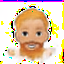

In [276]:
img_cartoon